## **프로젝트 : CIFAR-10 이미지 생성하기**
* 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
* 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
* 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

### **STEP 1. 작업환경 구성하기**

In [1]:
# 필요한 라이브러리 import 
import os
import glob
import time

import PIL
import imageio
import imageio.v2 as imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from IPython import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

### **STEP 2. 데이터셋 구성하기**
* 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
* 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [2]:
# 데이터셋 구성
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

이미지는 32x32 픽셀 크기이고 RGB 컬러 채널을 가지고 있다.  
따라서 각 이미지는 32x32x3의 형태를 가지고 있다.

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


각 픽셀은 0~255 사이의 정숫값을 가진다.  

이번 프로젝트에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠주자.

In [4]:
# 이미지를 -1, 1로 정규화
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
# 데이터셋 shape 확인
train_x.shape

(50000, 32, 32, 3)

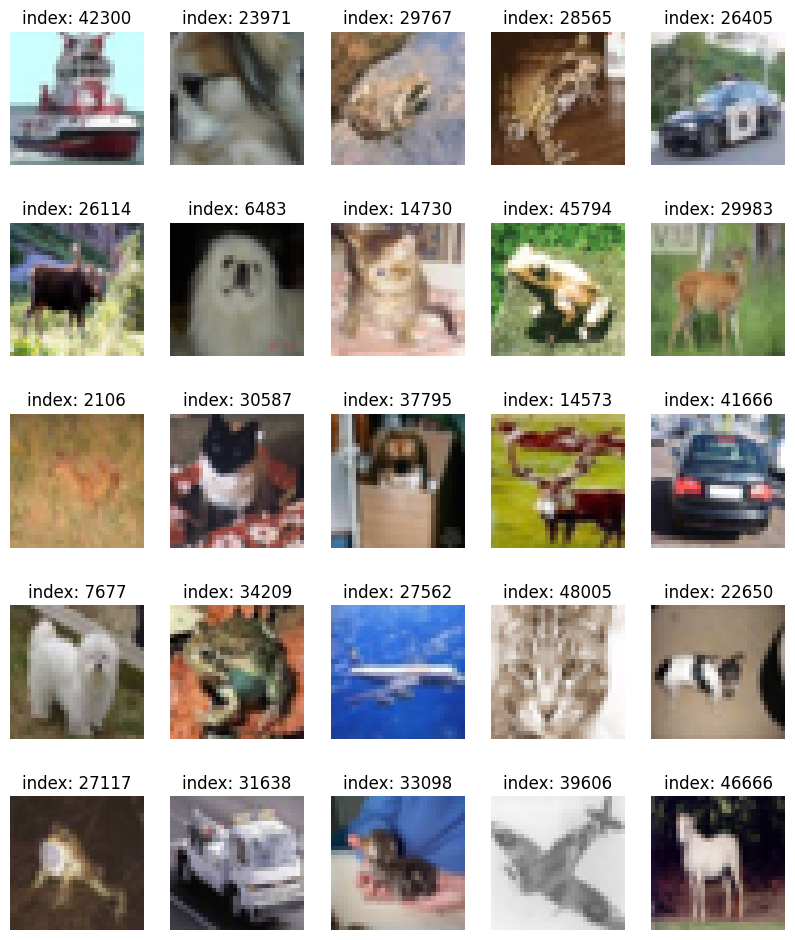

In [6]:
# 학습 데이터 시각화
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(0, 50000)
    image = (train_x[random_index] + 1) / 2.0 # [0, 1]로 클리핑
    plt.imshow(image)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [7]:
# 미니배치 데이터셋 구성
BUFFER_SIZE = 50000 # 총 데이터 사이즈와 같거나 크게 설정
BATCH_SIZE = 256 # 모델이 한 번에 학습할 데이터의 양

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### **STEP 3. 생성자 모델 구현하기**
* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [9]:
def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [10]:
generator= make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [11]:
# 노이즈 벡터 생성
noise = tf.random.normal([1, 100])

In [12]:
# 랜덤 이미지 생성
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

[1, 32, 32, 3] 사이즈의 이미지가 잘 생성되었다.  
첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가진다.

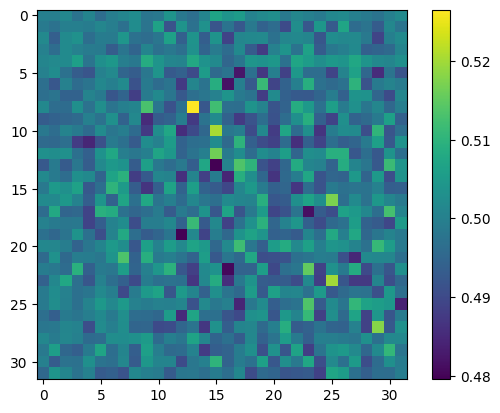

In [13]:
# 픽셀 값의 정규화 복원
generated_image = (generated_image + 1) / 2.0

# 이미지 시각화
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

matplotlib 라이브러리는 2차원 이미지만 표시할 수 있기 때문에, 데이터를 2차원으로 평탄화하기 위해 0번째와 3번째 축의 인덱스를 0으로 설정했다.

### **STEP 4. 판별자 모델 구현하기**
* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
* 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [14]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Fourth: Flatten Layer
    model.add(layers.Flatten())

    # Fifth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02400732]], dtype=float32)>

### **STEP 5. 손실함수와 최적화 함수 구현하기**
* 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
* 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# 생성자 손실 함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
# 판별자 손실 함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
# 판별자 정확도 계산 함수
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [21]:
# 생성자 옵티마이저
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = (1e-4)*2, beta_1 = 0.5)
# 판별자 옵티마이저
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = (1e-4)*2, beta_1 = 0.5)

In [22]:
# 생성할 이미지에 사용할 시드 노이즈 생성
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### **STEP 6. 훈련과정 상세 기능 구현하기**
* 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
* 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
* training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [23]:
@tf.function
def train_step(images): # 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # tf.GradientTape() 오픈
        generated_images = generator(noise, training=True) # generated_images 생성

        # discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    # gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy # 리턴값

In [24]:
# 훈련 과정 동안 생성한 이미지를 시각화하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8')) # reverse of normalization
        plt.axis('off')
   
    plt.savefig('C:/Users/Minjoo Lee/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

In [25]:
# 생성자/판별자의 히스토리(history)를 그래프로 시각화하는 함수
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('C:/Users/Minjoo Lee/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

In [26]:
# 모델을 저장하는 checkpoint 모듈 설정
checkpoint_dir = 'C:/Users/Minjoo Lee/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### **STEP 7. 학습 과정 진행하기**
* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [28]:
save_every = 5
EPOCHS = 200

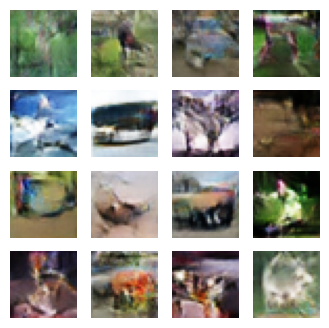

Time for training : 1800 sec


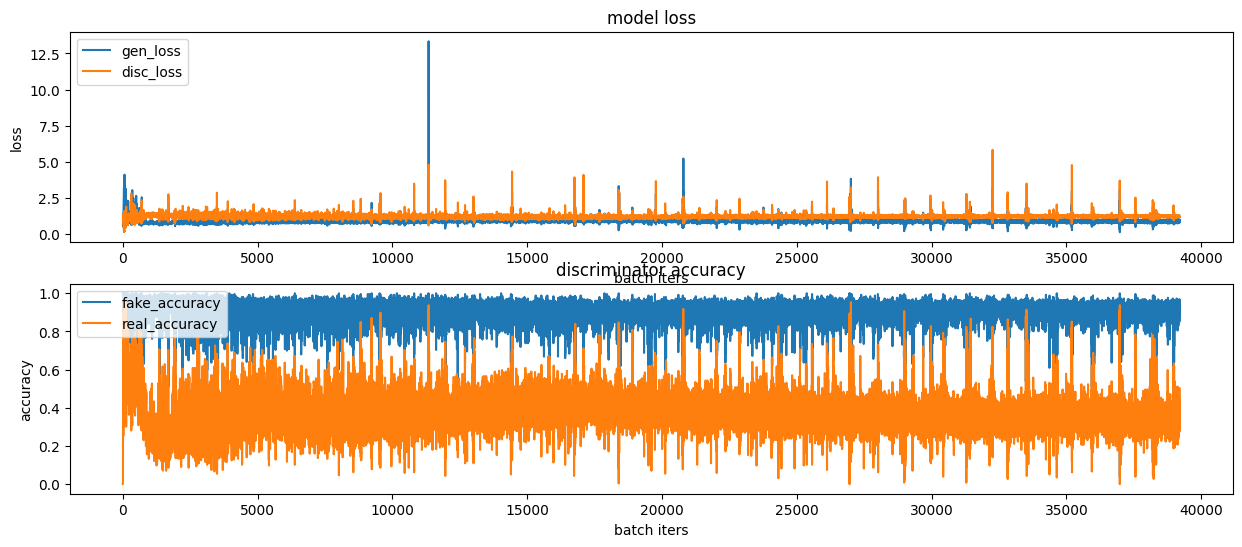

Wall time: 30min 1s


In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

In [30]:
anim_file = 'C:/Users/Minjoo Lee/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('C:/Users/Minjoo Lee/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

### **STEP 8. (optional) GAN 훈련 과정 개선하기**
* STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
* 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

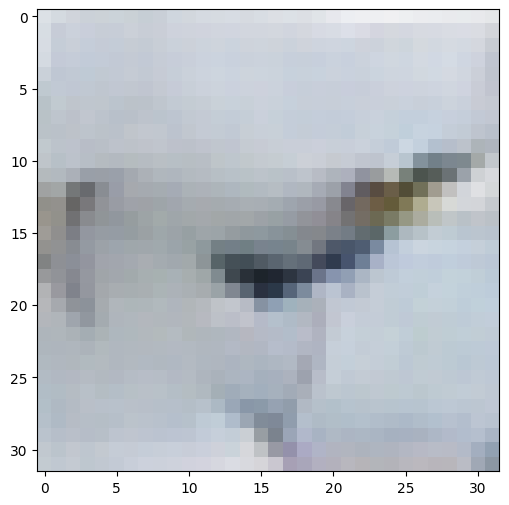

In [31]:
checkpoint_dir = 'C:/Users/Minjoo Lee/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5 # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show() # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것

생성된 이미지는 알아보기 어려운 것을 확인할 수 있다.  

500번의 추가 에포크를 실행하여 모델을 더 학습시켜보기로 했다.

In [32]:
EPOCHS = 500

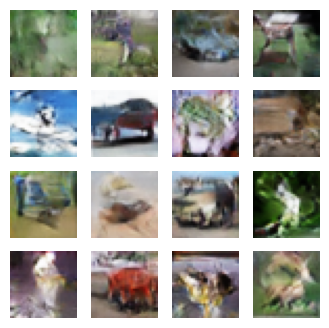

Time for training : 4986 sec


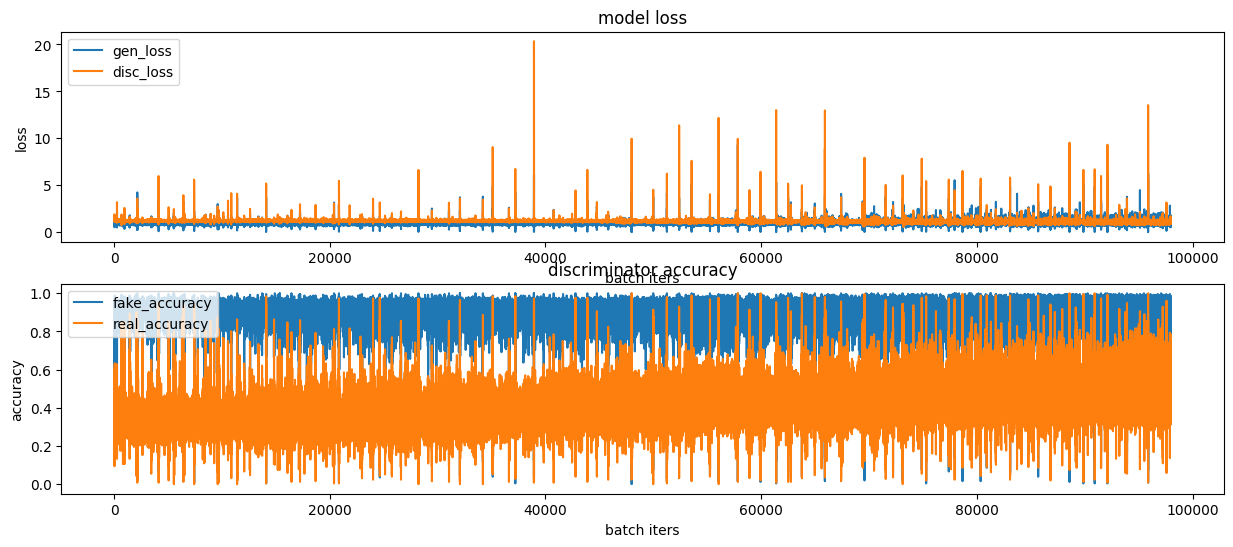

Wall time: 1h 23min 9s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

In [34]:
anim_file = 'C:/Users/Minjoo Lee/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_4.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('C:/Users/Minjoo Lee/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

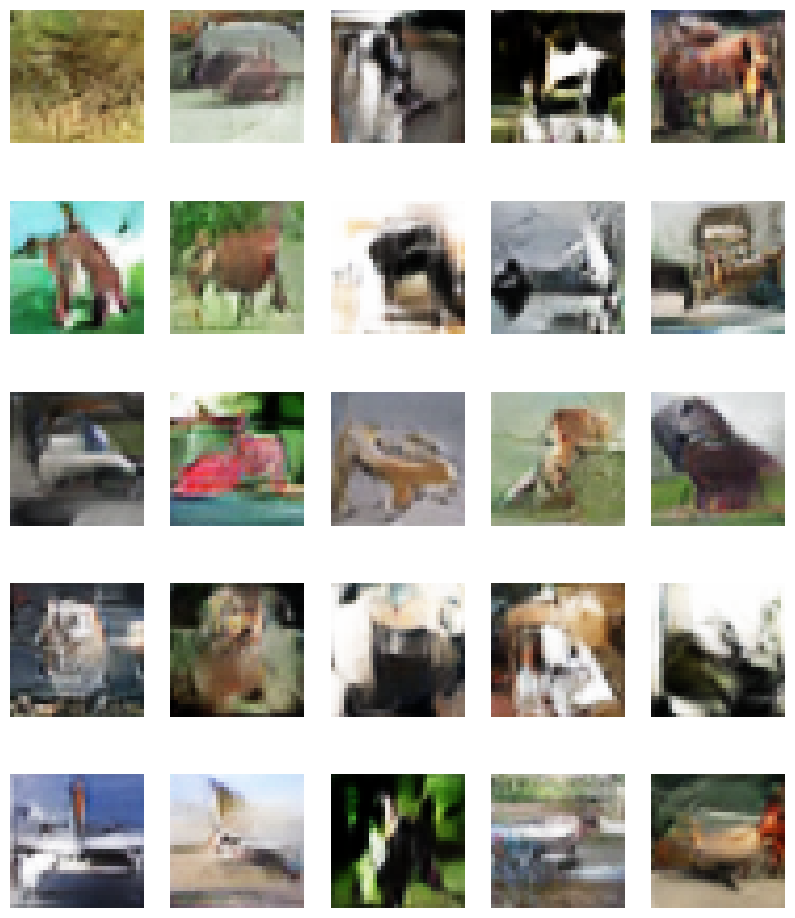

In [35]:
# checkpoint를 통해 모델 로드
checkpoint_dir = 'C:/Users/Minjoo Lee/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5 # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()

형체가 완전히 뚜렷하지는 않지만 이전보다는 선명해진 것을 확인할 수 있다.  

이제 최종적으로 모델구조와 하이퍼파라미터 변경 전과 후를 시각적으로 비교해보자.

#### **Baseline Model**

| **생성자 모델** | **판별자 모델** |
| :---: | :---: |
|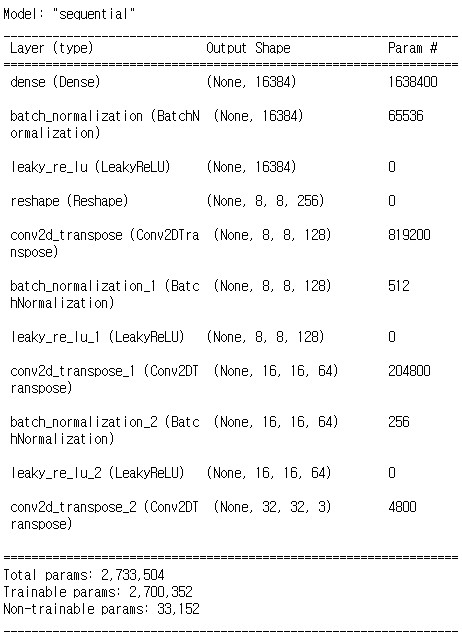|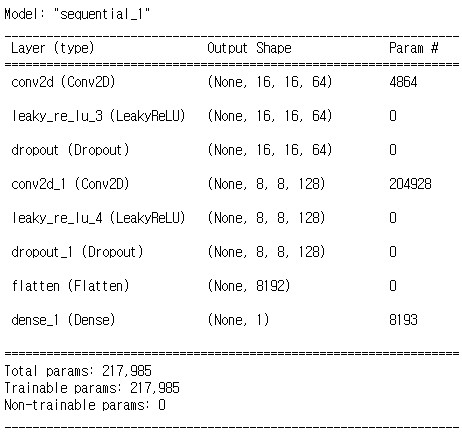

| **EPOCH = 200** | **EPOCH = 300 (추가 학습)** |
| :---: | :---: |
|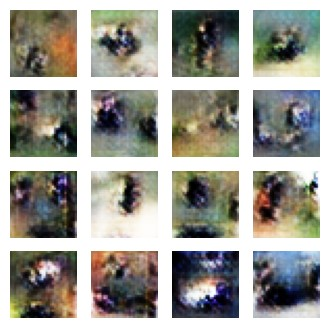|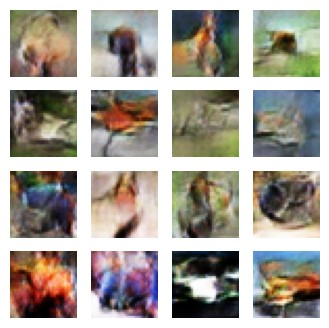
|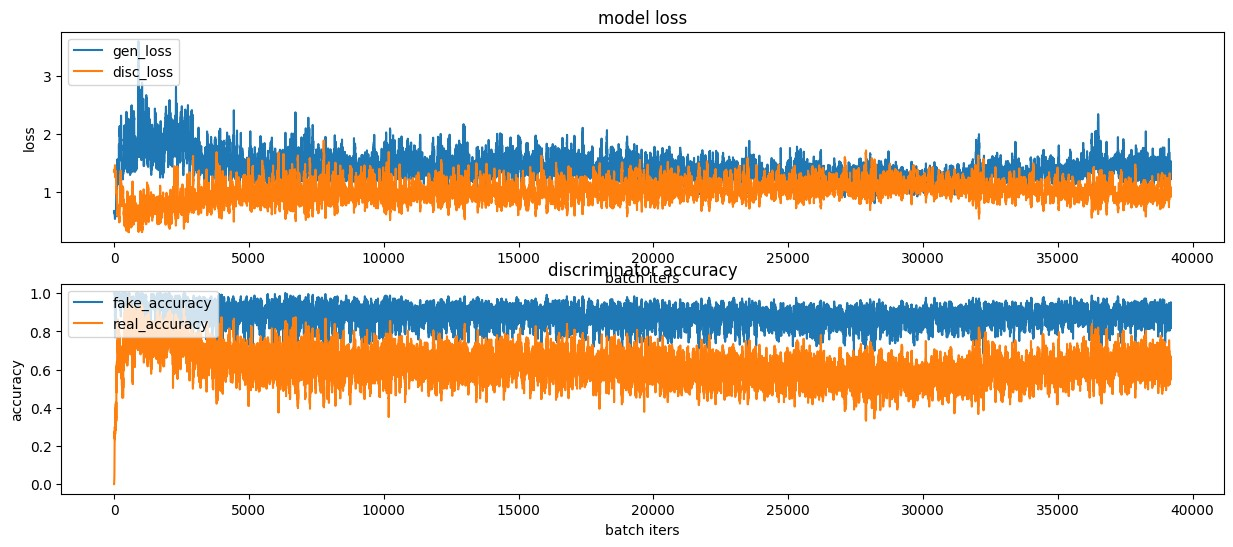|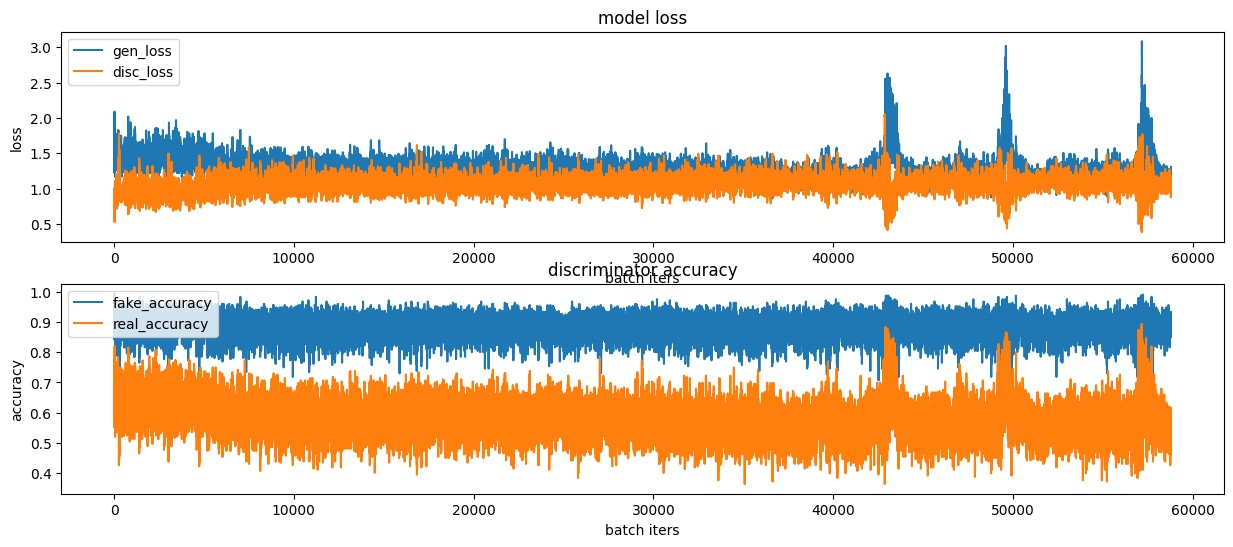

많은 에포크를 돌릴수록 모델은 더 많은 학습을 진행하고 데이터의 패턴을 더욱 잘 파악할 수 있다.  
이로 인해 생성된 이미지의 품질이 서서히 향상되고, 세부적인 특징이 뚜렷해지는 것을 관찰할 수 있다.

#### **Final Model**
* 레이어 추가
* layers.LeakyReLU(alpha=0.2)
* tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

| **생성자 모델** | **판별자 모델** |
| :---: | :---: |
|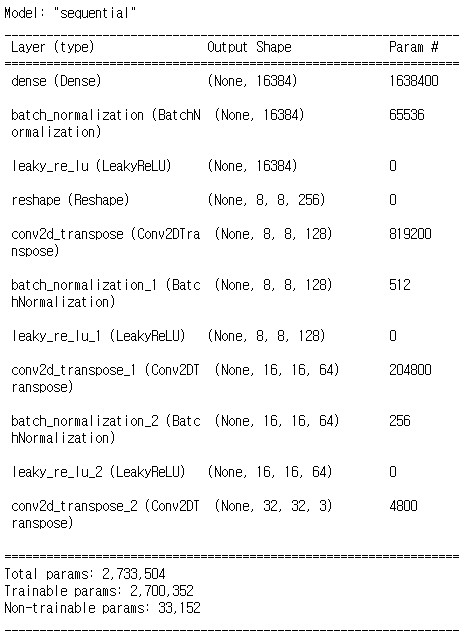|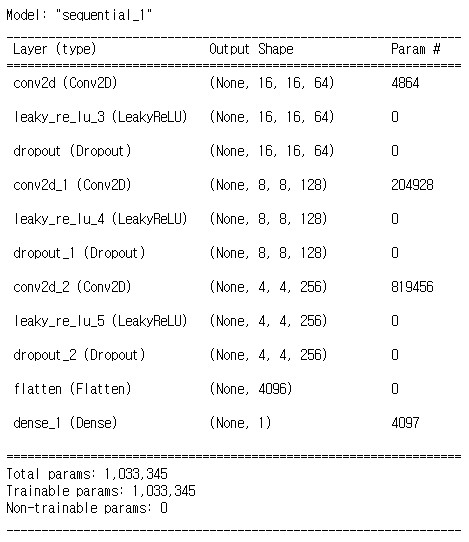

| **EPOCH = 200** | **EPOCH = 500 (추가 학습)** |
| :---: | :---: |
|![cifar10_dcgan_3.gif](/files/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_3.gif)|![cifar10_dcgan_4.gif](/files/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_4.gif)
|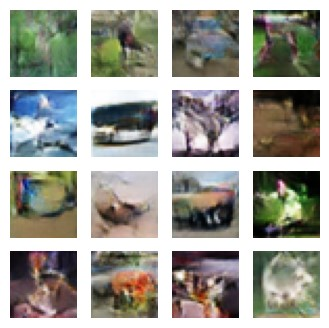|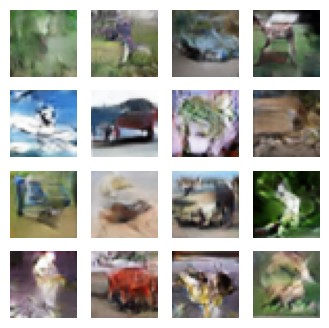
|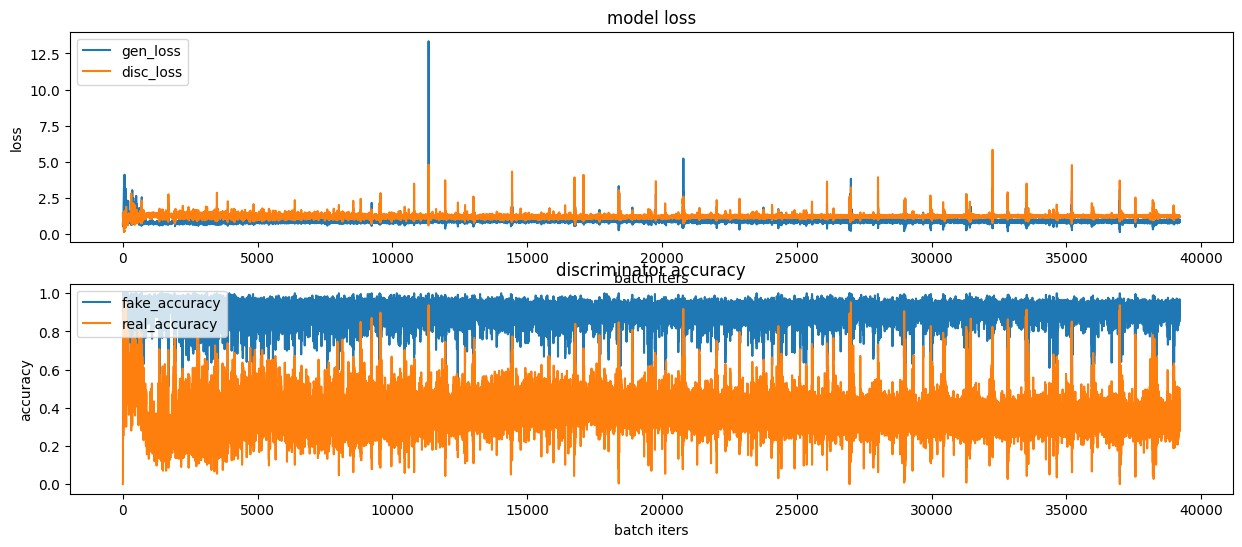|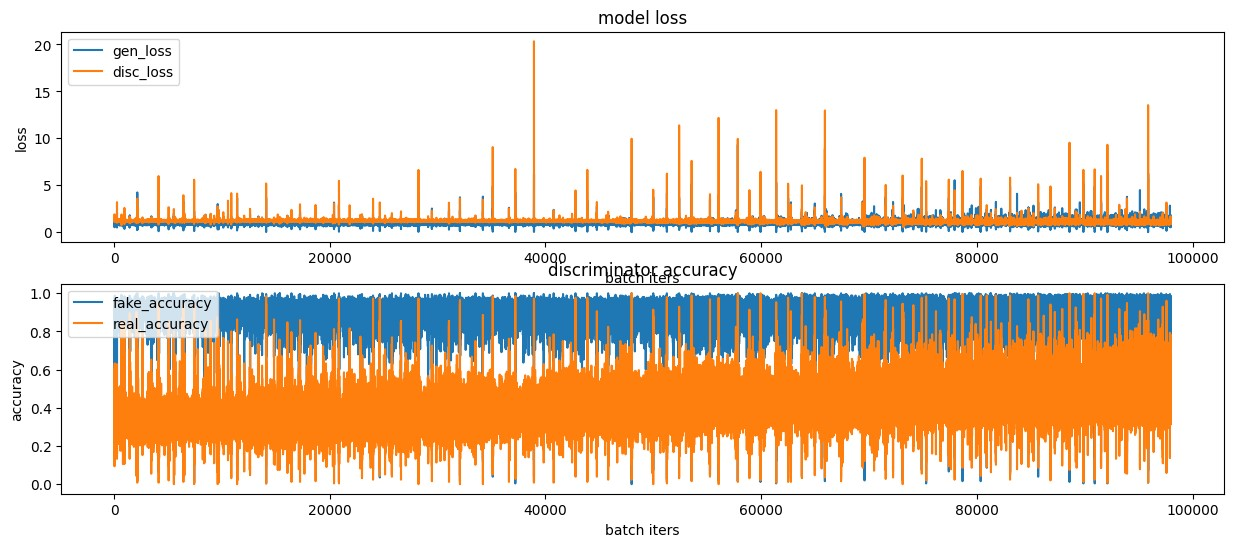

gif를 통해 생성 이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있는 것을 확인할 수 있다.  

---

### **프로젝트 회고**
이번 프로젝트는 지금까지 한 프로젝트 중에서 제일 어려웠던 것 같다. 처음에는 checkpoint가 정확히 어떤 기능을 하고 왜 필요한지 이해하는 데 시간이 많이 걸렸다. 또한, 모델 구조를 변경하는 경우 checkpoint를 언제 불러와서 사용해야 하는지에 대해서도 이해하기 어려웠다. 모델 구조를 변경하면서도 기존에 학습한 모델의 결과를 그대로 유지하고 새로운 모델로도 기존의 코드를 가지고 그대로 학습을 진행하고 싶어 함수를 사용하거나 변수명을 변경해보았지만 효과적인 방법을 찾지 못했다. 결과적으로는 기존의 모델 결과를 따로 저장하고 최종 이미지와 그래프를 업로드하여 비교하는 방식을 택했다. 이번 프로젝트를 진행하면서 함수나 클래스를 사용해서 코드를 효율적으로 작성하는 것의 중요성을 느꼈고, 학습하는 동안 시간을 잘 활용하는 것이 중요하다는 것을 깨달았다. 또한, 학습 시간이 오래 걸리기 때문에 다양한 시도를 하기 어렵다는 점을 경험하게 되었다. 마지막에는 gif 파일을 업로드하는 부분에서 어려움을 겪었는데, 아주 간단한 작업이라고 생각되었지만 해결하는 데 많은 시간이 걸려 매우 답답함을 느꼈다. 앞으로도 함수나 클래스를 활용하여 효율적인 코드 작성에 노력하고, 학습 시간을 최대한 활용하여 다양한 시도를 해보는 것이 중요할 것 같다.

#### **새로 알게 된 것!**
* 판별 모델: 데이터를 분류하거나 특정 값을 맞히는 모델
* 생성 모델: 학습한 데이터와 유사한 새로운 데이터를 생성하는 모델

**여러가지 생성 모델링 기법**
* Pix2Pix: 간단한 이미지를 실제 사진으로 변환해주는 모델. 입력과 출력 데이터셋이 필요한 단방향 변환 모델.  
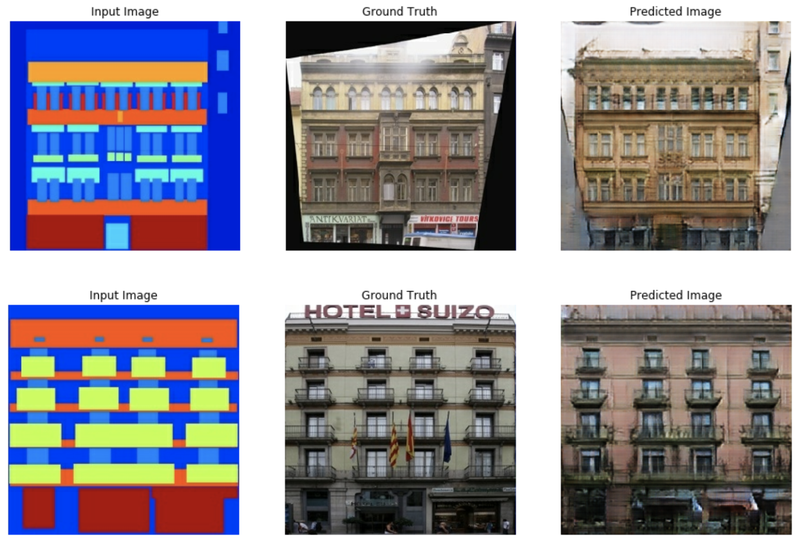

* CycleGAN: 두 도메인 사이의 이미지 변환을 수행하는 모델. 양방향 변환이 가능하며, 입력과 출력 데이터셋이 필요하지 않음.  
![image-2.png](attachment:image-2.png)

* Neural Style Transfer: 두 이미지를 결합하여 입력 이미지의 스타일을 다른 이미지로 옮기는 모델. 스타일 이미지와 내용 이미지를 입력으로 받아 스타일 특징을 적용한 결과 이미지 생성.  
![image-3.png](attachment:image-3.png)

**GAN의 구조**
* 생성자(Generator): 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성
* 판별자(Discriminator): 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real 인지, Fake 인지에 대한 판단 정도를 실숫값으로 출력

서로 경쟁하듯 이루어진 모델의 구조 덕분에 이름에 "Adversarial(적대적인)"이 들어가게 된 것이다.
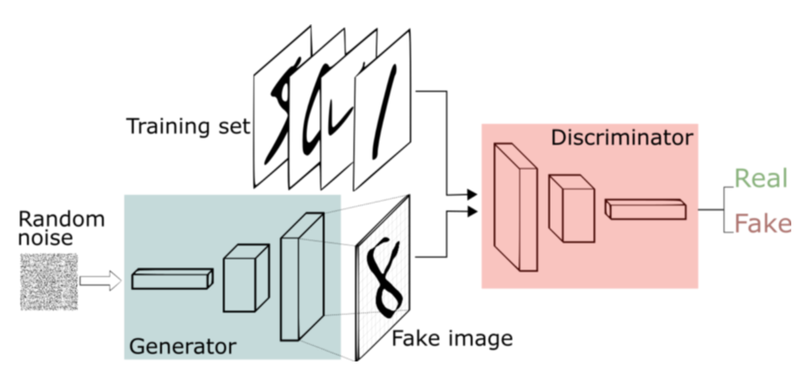

**참고한 레퍼런스**
<br>AWS DeepComposer https://www.youtube.com/watch?v=XH2EbK9dQlg&t=3s
<br>Image-to-Image Translation with Conditional Adversarial Networks https://arxiv.org/pdf/1611.07004.pdf
<br>tf.data.Dataset https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
<br>Generative Adversarial Nets https://arxiv.org/pdf/1406.2661.pdf
<br>Generative Models - openai https://openai.com/research/generative-models
<br>심층 합성곱 생성적 적대 신경망 https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko
<br>What is Transposed Convolutional Layer? https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11
<br>Batch Normalization https://eehoeskrap.tistory.com/430
<br>활성화 함수 (activation function) https://newly0513.tistory.com/20
<br>문과생도 이해하는 딥러닝 (8) - 신경망 학습 최적화 https://sacko.tistory.com/42
<br>python decorator (데코레이터) 어렵지 않아요https://schoolofweb.net/blog/posts/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0-decorator/
<br>How to Train a GAN? Tips and tricks to make GANs work https://github.com/soumith/ganhacks
<br>Improved Techniques for Training GANs(paper) https://proceedings.neurips.cc/paper_files/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf
<br>10 Lessons I Learned Training GANs for one Year https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628
<br>Tips for Training Stable Generative Adversarial Networks https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/